# Applying U-Net for Medical Image Segmentation: A Case Study

### Carson Keller

## Importing Necessary Packages

In [2]:
import os
import math
import cv2
import glob
import PIL
from PIL import Image, ImageOps
import shutil
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import data
from skimage.util import montage
import skimage.transform as skTrans
from skimage.transform import rotate
from skimage.transform import resize

#necessary library to view image files
import nilearn as nl
import nilearn.plotting as nlplt
import nibabel as nib

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras.engine import data_adapter
import keras.backend as K
from keras import Input
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from keras.optimizers import Adam
from keras.models import *
from keras.layers import *
from keras.utils import plot_model
from keras.metrics import MeanIoU

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

np.set_printoptions(precision=3, suppress=True)

In [3]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Defining Variables

In [4]:
classes = {
    0 : "NOT tumor",
    1 : "NECROTIC/CORE",
    2 : "EDEMA",
    3 : "ENHANCING"
}

num_slices = 145
slice_start = 5
img_size = 128

## Creating Filepaths and Displaying Test Images




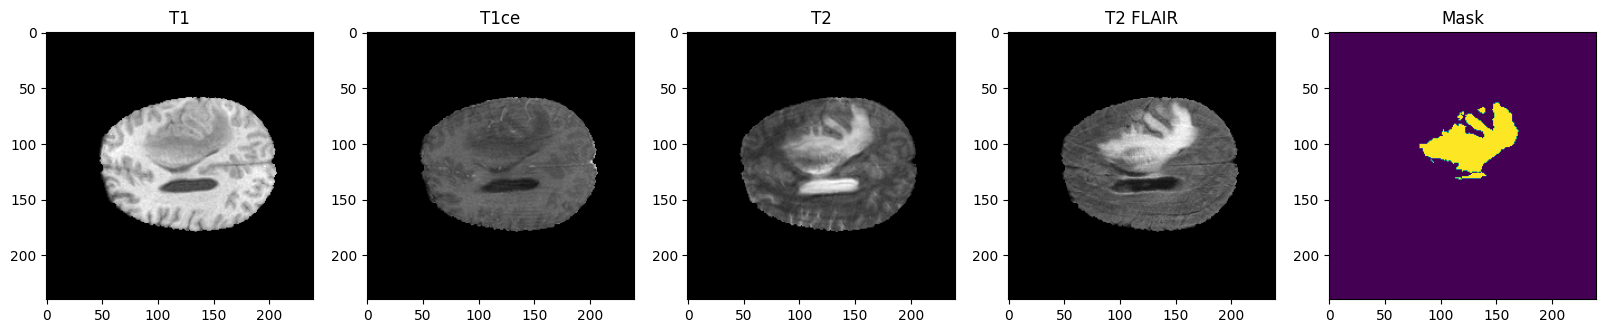

In [5]:
dirpath = os.getcwd()
PATH = os.path.join(dirpath, "drive/MyDrive/College/Boise State University/SPRING 2024/CS434/FINAL PROJECT/")
train_dataset_path = os.path.join(PATH, "input/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/")
validation_dataset_path = os.path.join(PATH, "input/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData")

test_image_t1 = nib.load(os.path.join(train_dataset_path + "BraTS20_Training_001/BraTS20_Training_001_t1.nii")).get_fdata()
test_image_t1ce = nib.load(os.path.join(train_dataset_path + "BraTS20_Training_001/BraTS20_Training_001_t1ce.nii")).get_fdata()
test_image_t2 = nib.load(os.path.join(train_dataset_path + "BraTS20_Training_001/BraTS20_Training_001_t2.nii")).get_fdata()
test_image_t2_flair = nib.load(os.path.join(train_dataset_path + "BraTS20_Training_001/BraTS20_Training_001_flair.nii")).get_fdata()
test_mask = nib.load(os.path.join(train_dataset_path + "BraTS20_Training_001/BraTS20_Training_001_seg.nii")).get_fdata()

fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1,5, figsize = (20, 10))
slice_w = 25
ax1.imshow(test_image_t1[:, :, test_image_t1.shape[0] // 2 - slice_w], cmap='gray')
ax1.set_title("T1")
ax2.imshow(test_image_t1ce[:, :, test_image_t1ce.shape[0] // 2 - slice_w], cmap='gray')
ax2.set_title("T1ce")
ax3.imshow(test_image_t2[:, :, test_image_t2.shape[0] // 2 - slice_w], cmap='gray')
ax3.set_title("T2")
ax4.imshow(test_image_t2_flair[:, :, test_image_t2_flair.shape[0] // 2 - slice_w], cmap='gray')
ax4.set_title("T2 FLAIR")
ax5.imshow(test_mask[:,:,test_mask.shape[0]//2-slice_w])
ax5.set_title("Mask")
plt.show()

## Displaying Scan Instance Voxel Array

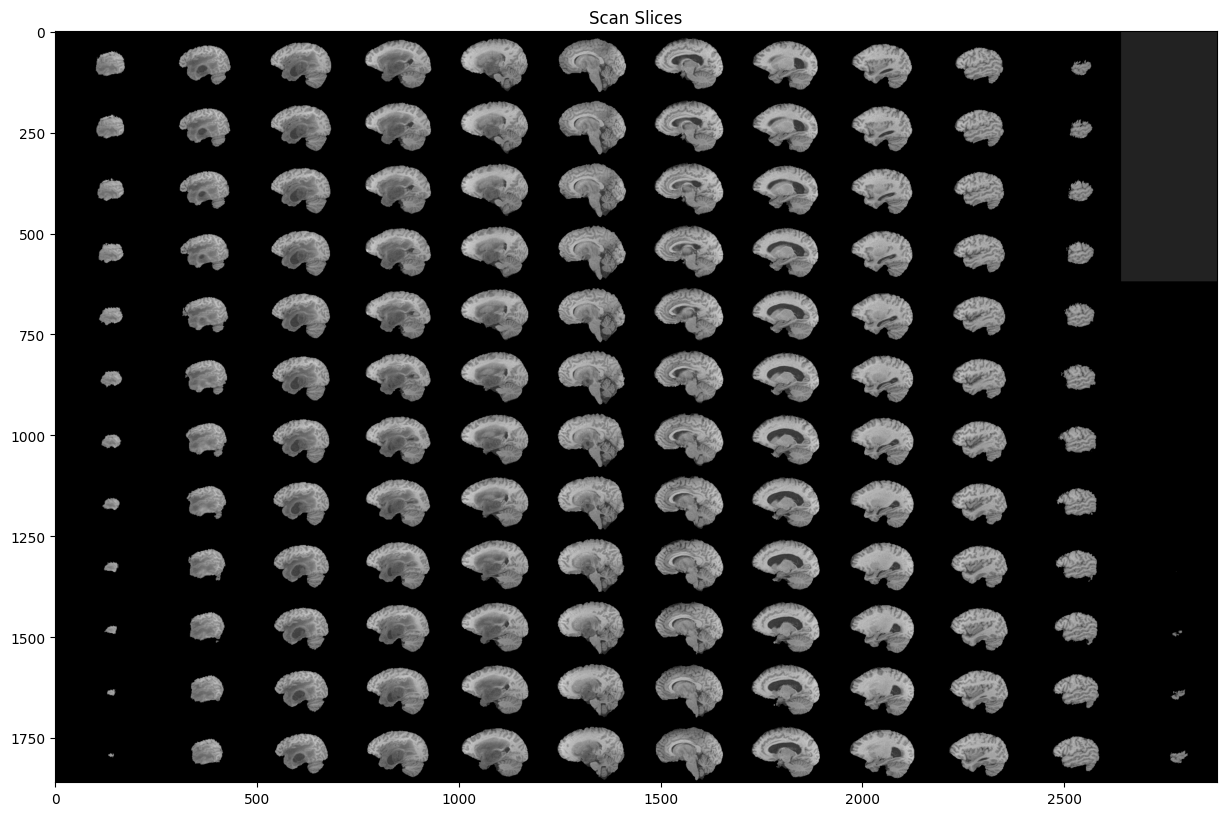

In [6]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_image_t1[50:-50, :, :]), 90, resize=True), cmap='gray')
ax1.set_title("Scan Slices")
plt.show()

## Displaying Scan Instance Mask Voxel Array

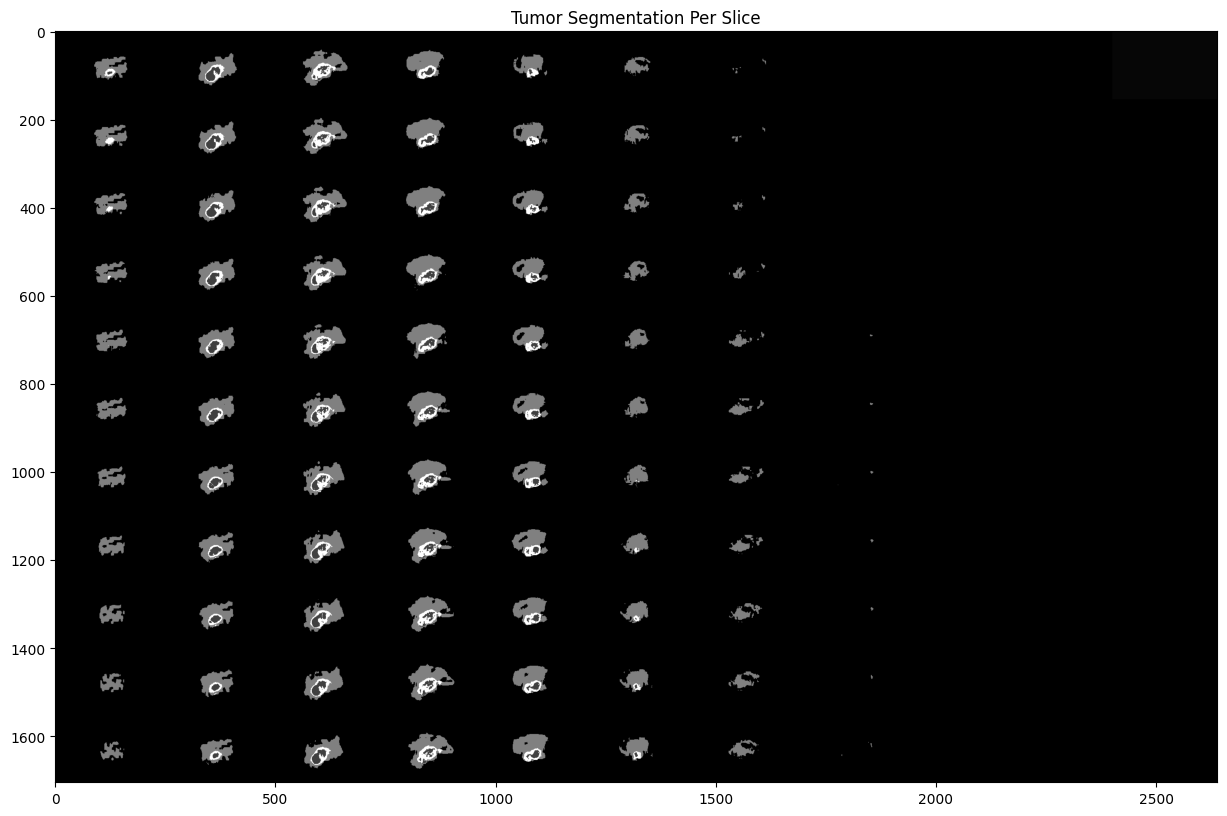

In [7]:
fig, ax1 = plt.subplots(1, 1, figsize = (15,15))
ax1.imshow(rotate(montage(test_mask[60:-60, :, :]), 90, resize=True), cmap ='gray')
ax1.set_title("Tumor Segmentation Per Slice")
plt.show()

## Applying and Displaying Imaging Treatments per Nilearn Package

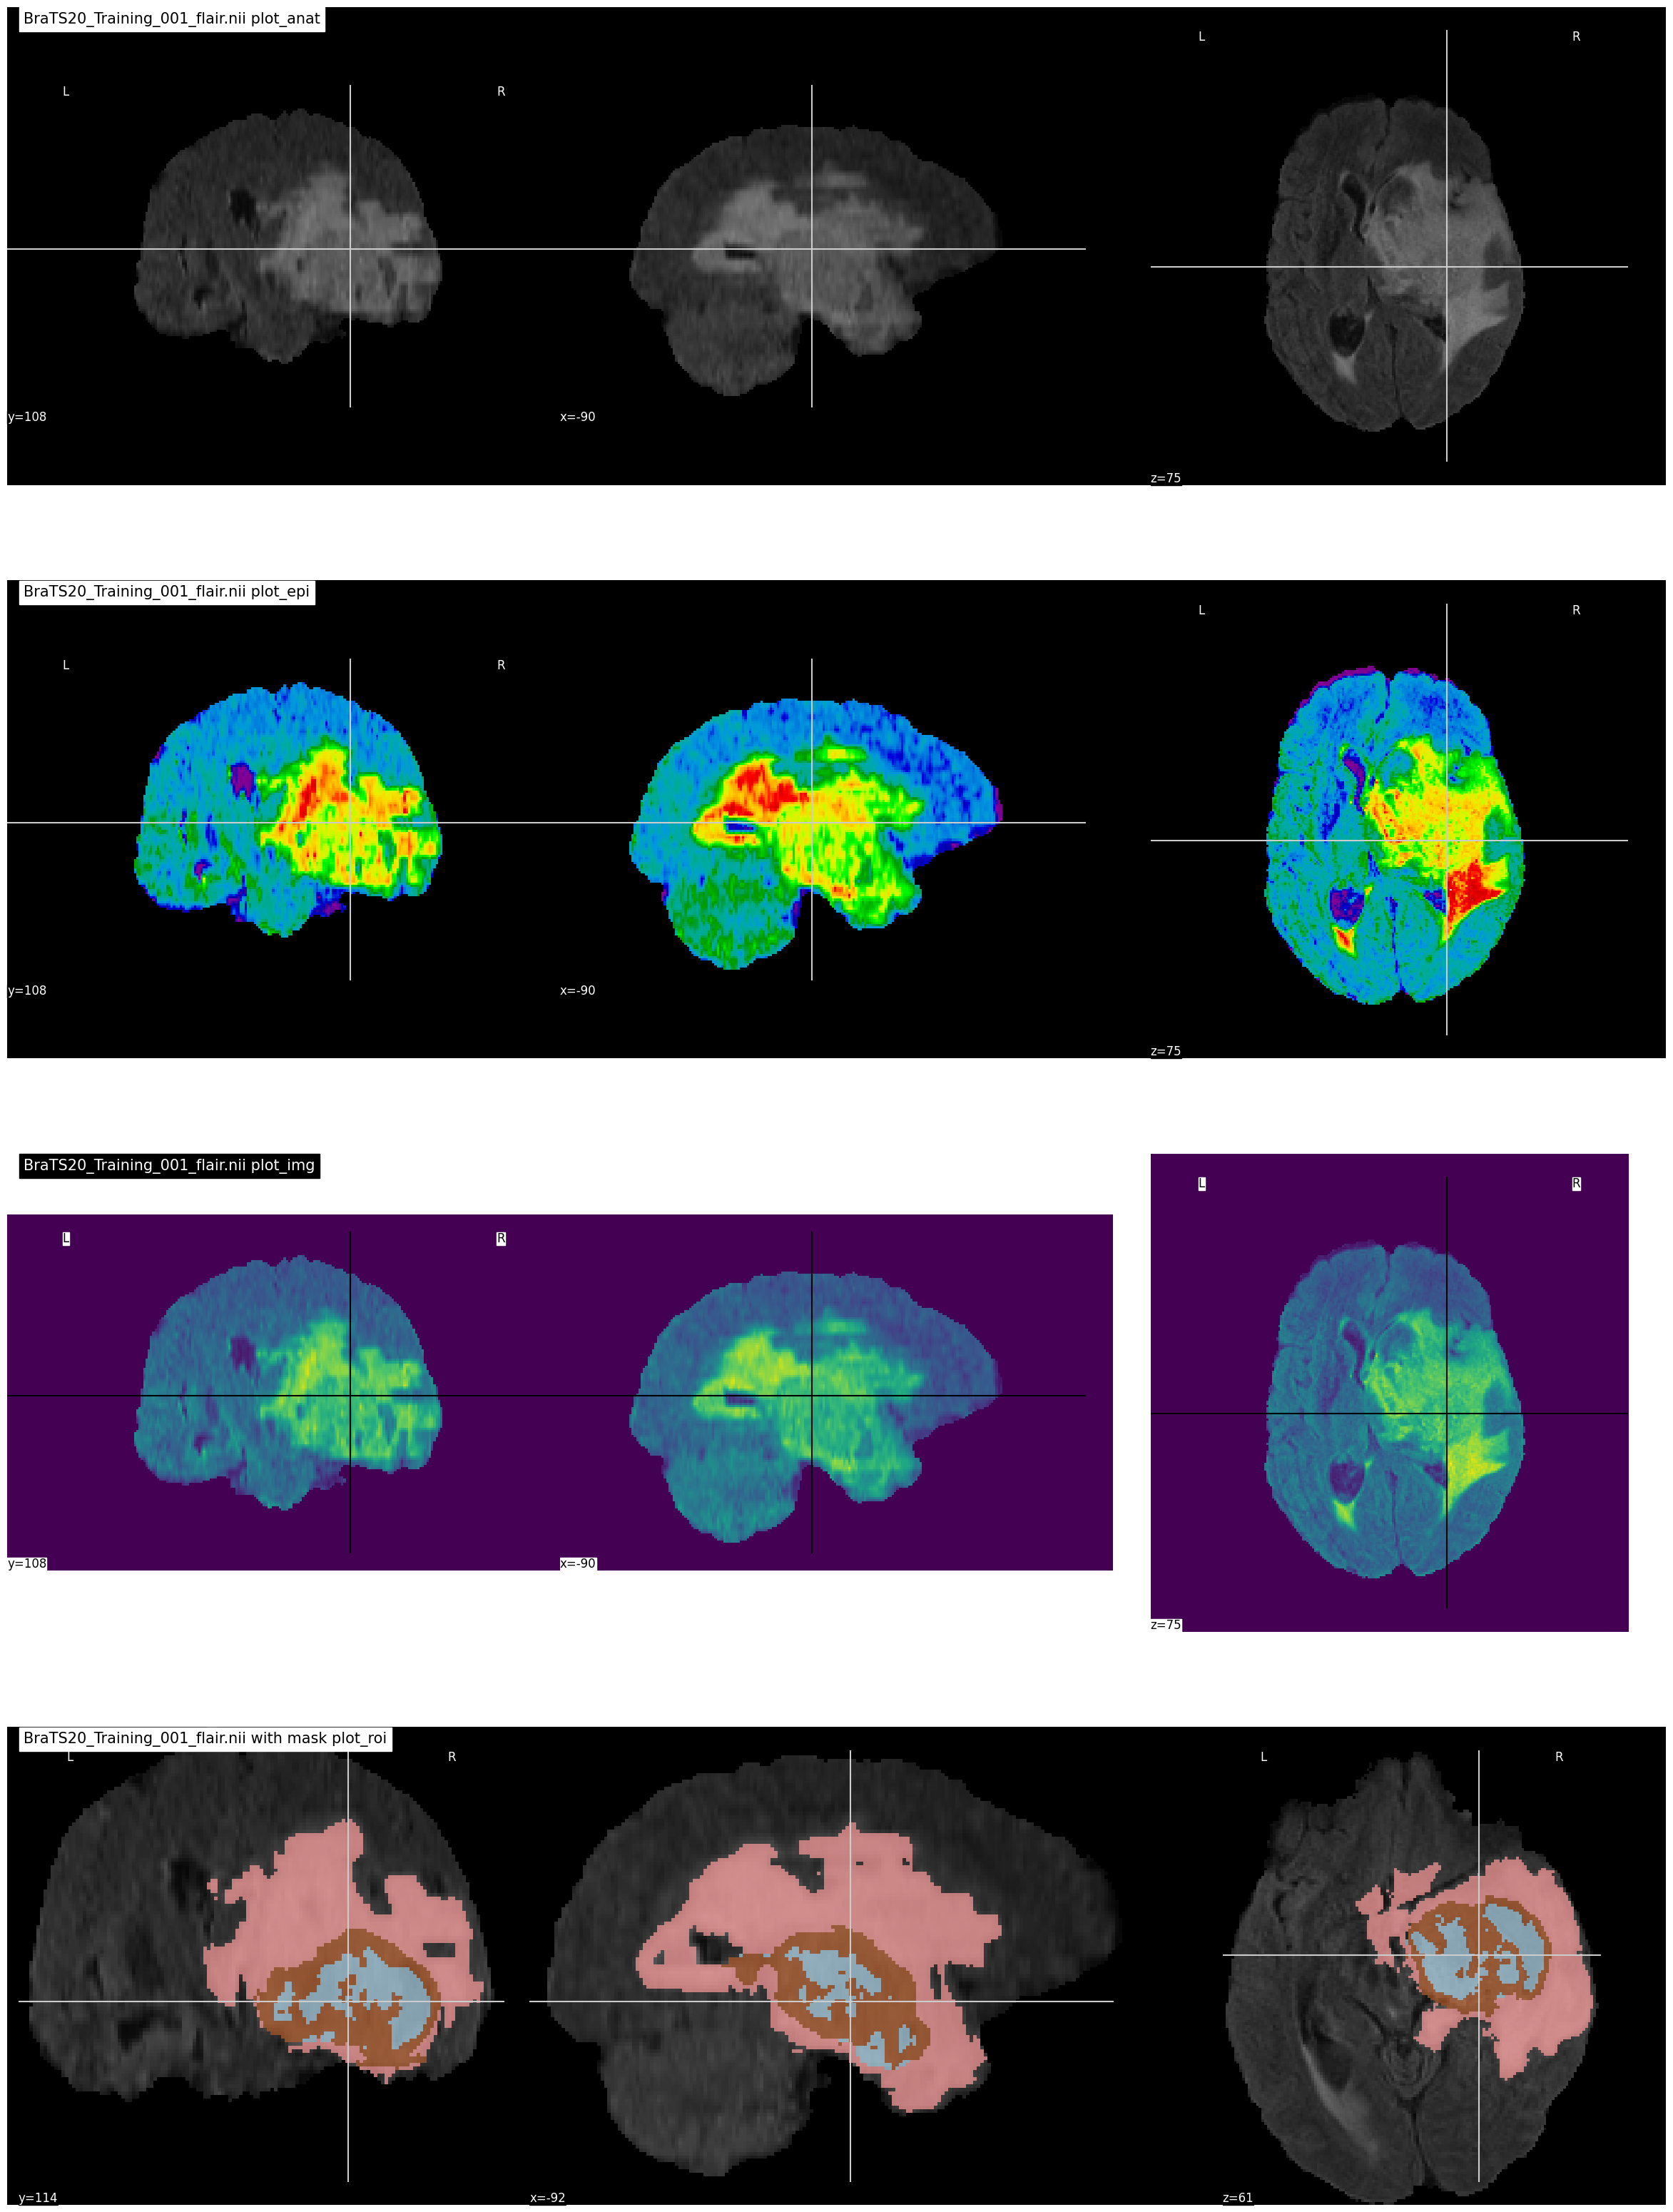

In [8]:
niimg = nl.image.load_img(os.path.join(train_dataset_path + "BraTS20_Training_001/BraTS20_Training_001_flair.nii"))
nimask = nl.image.load_img(os.path.join(train_dataset_path + "BraTS20_Training_001/BraTS20_Training_001_seg.nii"))

fig, axes = plt.subplots(nrows=4, figsize=(30, 40))


nlplt.plot_anat(niimg,
                title='BraTS20_Training_001_flair.nii plot_anat',
                axes=axes[0])

nlplt.plot_epi(niimg,
               title='BraTS20_Training_001_flair.nii plot_epi',
               axes=axes[1])

nlplt.plot_img(niimg,
               title='BraTS20_Training_001_flair.nii plot_img',
               axes=axes[2])

nlplt.plot_roi(nimask,
               title='BraTS20_Training_001_flair.nii with mask plot_roi',
               bg_img=niimg,
               axes=axes[3], cmap='Paired')

plt.show()

## Defining Evaluation Metrics

In [9]:
def dice_coef(y_true, y_pred, smooth=1.0):
    class_num = 4
    for i in range(class_num):
        y_true_f = K.flatten(y_true[:,:,:,i])
        y_pred_f = K.flatten(y_pred[:,:,:,i])
        intersection = K.sum(y_true_f * y_pred_f)
        loss = ((2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth))
        if i == 0:
            total_loss = loss
        else:
            total_loss = total_loss + loss
    total_loss = total_loss / class_num
    return total_loss

def dice_coef_necrotic(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,1] * y_pred[:,:,:,1]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,1])) + K.sum(K.square(y_pred[:,:,:,1])) + epsilon)

def dice_coef_edema(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,2] * y_pred[:,:,:,2]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,2])) + K.sum(K.square(y_pred[:,:,:,2])) + epsilon)

def dice_coef_enhancing(y_true, y_pred, epsilon=1e-6):
    intersection = K.sum(K.abs(y_true[:,:,:,3] * y_pred[:,:,:,3]))
    return (2. * intersection) / (K.sum(K.square(y_true[:,:,:,3])) + K.sum(K.square(y_pred[:,:,:,3])) + epsilon)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())

## Attempt To Develop and Implement Custom Loss Function

In [10]:
# class AsymmetricUnifiedFocalLoss(keras.losses.Loss):
#     def __init__(self, delta, reduction=keras.losses.Reduction.AUTO, name="AsymmetricUnifiedFocalLossClass", **kwargs):
#         self.delta = 0.6
#         self.reduction = reduction
#         super().__init__(delta, reduction, name, **kwargs)

#     def call(self, y_true, y_pred):
#         asymmetric_ftl = asymmetric_focal_tversky_loss(self.delta, 0.5)(y_true, y_pred)
#         asymmetric_fl = asymmetric_focal_loss(self.delta, 0.5)(y_true, y_pred)
#         loss_value = (0.5 * asymmetric_ftl) +((1 - 0.5) * asymmetric_fl)
#         return loss_value

#     def get_config(self):
#         base_config = super().get_config()
#         return {**base_config,
#                 "delta" : self.delta,
#                 "reduction" : self.reduction
#                 }

# def identify_axis(shape):
#     if len(shape) == 5 : return [1, 2, 3]
#     elif len(shape) == 4 : return [1, 2]

# def asymmetric_focal_tversky_loss(delta, gamma):
#     def loss_function(y_true, y_pred):
#         epsilon = K.epsilon()
#         y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
#         axis = identify_axis(y_true.get_shape())

#         true_positives = K.sum(y_true * y_pred, axis=axis)
#         false_negatives = K.sum(y_true * (1 - y_pred), axis=axis)
#         false_positives = K.sum((1 - y_true) * y_pred, axis=axis)
#         dice_class = (true_positives + epsilon) / (true_positives + (delta * false_negatives) + ((1 - delta) * false_positives) + epsilon)

#         back_dice = (1 - dice_class[:, 0])
#         fore_dice = (1 - dice_class[:, 1]) * K.pow(1 - dice_class[:, 1], -gamma)

#         loss = K.mean(tf.stack([back_dice, fore_dice], axis=-1))

#         return loss

#     return loss_function

# def asymmetric_focal_loss(delta, gamma):
#     def loss_function(y_true, y_pred):
#         epsilon = K.epsilon()
#         y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
#         axis = identify_axis(y_true.get_shape())

#         cross_entropy = -y_true * K.log(y_pred)

#         back_ce = K.pow(1 - y_pred[:, :, :, 0], gamma) * cross_entropy[:, :, :, 0]
#         back_ce = (1 - delta) * back_ce

#         fore_ce = cross_entropy[:, :, :, 1]
#         fore_ce = delta * fore_ce

#         loss = K.mean(K.sum(tf.stack([back_ce, fore_ce], axis=-1), axis=-1))

#         return loss

#     return loss_function

# def dice_coef(y_true, y_pred, smooth=1.0):
#     axis = identify_axis(y_true.get_shape())

#     true_positives = K.sum(y_true * y_pred, axis=axis)
#     false_negatives = K.sum(y_true * (1 - y_pred), axis=axis)
#     false_positives = K.sum((1 - y_true) * y_pred, axis=axis)
#     dice_class = (2 * true_positives + smooth) / (2 * true_positives + false_positives + false_negatives + smooth)
#     dice_coef = K.mean(dice_class)

#     return dice_coef

# def precision(y_true, y_pred, smooth=1.0):
#     axis = identify_axis(y_true.get_shape())

#     true_positives = K.sum(y_true * y_pred, axis=axis)
#     false_negatives = K.sum(y_true * (1 - y_pred), axis=axis)
#     false_positives = K.sum((1 - y_true) * y_pred, axis=axis)
#     precision_class = (true_positives + smooth) / (true_positives + false_positives + smooth)
#     precision = K.mean(precision_class)

#     return precision

# def recall(y_true, y_pred, smooth=1.0):
#     axis = identify_axis(y_true.get_shape())

#     true_positives = K.sum(y_true * y_pred, axis=axis)
#     false_negatives = K.sum(y_true * (1 - y_pred), axis=axis)
#     false_positives = K.sum((1 - y_true) * y_pred, axis=axis)
#     recall_class = (true_positives + smooth) / (true_positives + false_negatives + smooth)
#     recall = K.mean(recall_class)

#     return recall

## Traditional U-Net Model Structure

In [11]:
def build_unet(inputs, ker_init, dropout):
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
    drop5 = Dropout(dropout)(conv5)

    up6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(drop5))
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)

    up7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv6))
    merge7 = concatenate([conv3,up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)

    up8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer = ker_init)(conv8)

    up9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(conv8))
    merge9 = concatenate([conv1,up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)

    conv10 = Conv2D(4, (1, 1), activation='softmax')(conv9)

    return Model(inputs=inputs, outputs=conv10)

## Model "Playground" For Testing Model Variations

In [12]:
# def build_unet(inputs, ker_init, dropout):
#     conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(inputs)
#     conv1 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv1)
#     drop1 = Dropout(dropout)(conv1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

#     conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool1)
#     conv2 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv2)
#     drop2 = Dropout(dropout)(conv2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

#     conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool2)
#     conv3 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv3)
#     drop3 = Dropout(dropout)(conv3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

#     conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool3)
#     conv4 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv4)
#     drop4 = Dropout(dropout)(conv4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer=ker_init)(pool4)
#     conv5 = Conv2D(1024, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv5)
#     drop5 = Dropout(dropout)(conv5)

#     up6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(drop5))
#     merge6 = concatenate([drop4, up6], axis=3)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge6)
#     conv6 = Conv2D(512, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv6)
#     drop6 = Dropout(dropout)(conv6)

#     up7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(drop6))
#     merge7 = concatenate([drop3,up7], axis=3)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge7)
#     conv7 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv7)
#     drop7 = Dropout(dropout)(conv7)

#     up8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(drop7))
#     merge8 = concatenate([drop2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge8)
#     conv8 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer = ker_init)(conv8)
#     drop8 = Dropout(dropout)(conv8)

#     up9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(UpSampling3D(size=(2, 2, 2))(drop8))
#     merge9 = concatenate([drop1,up9], axis=3)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(merge9)
#     conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer=ker_init)(conv9)
#     drop9 = Dropout(dropout)(conv9)

#     conv10 = Conv2D(4, (1, 1), activation='softmax')(drop9)

#     return Model(inputs=inputs, outputs=conv10)

In [13]:
# def build_unet(inputs, ker_init, dropout):
#     conv1 = Conv2D(64, 3, padding='same')(inputs)
#     normal1 = BatchNormalization()(conv1)
#     activ1 = PReLU(alpha_initializer=ker_init)(normal1)
#     conv1 = Conv2D(64, 3, padding='same')(activ1)
#     normal1 = BatchNormalization()(conv1)
#     activ1 = PReLU(alpha_initializer=ker_init)(normal1)
#     drop1 = Dropout(dropout)(activ1)
#     pool1 = MaxPooling2D(pool_size=(2, 2))(drop1)

#     conv2 = Conv2D(128, 3, padding='same')(pool1)
#     normal2 = BatchNormalization()(conv2)
#     activ2 = PReLU(alpha_initializer=ker_init)(normal2)
#     conv2 = Conv2D(128, 3, padding='same')(activ2)
#     normal2 = BatchNormalization()(conv2)
#     activ2 = PReLU(alpha_initializer=ker_init)(normal2)
#     drop2 = Dropout(dropout)(activ2)
#     pool2 = MaxPooling2D(pool_size=(2, 2))(drop2)

#     conv3 = Conv2D(256, 3, padding='same')(pool2)
#     normal3 = BatchNormalization()(conv3)
#     activ3 = PReLU(alpha_initializer=ker_init)(normal3)
#     conv3 = Conv2D(256, 3, padding='same')(activ3)
#     normal3 = BatchNormalization()(conv3)
#     activ3 = PReLU(alpha_initializer=ker_init)(normal3)
#     drop3 = Dropout(dropout)(activ3)
#     pool3 = MaxPooling2D(pool_size=(2, 2))(drop3)

#     conv4 = Conv2D(512, 3, padding='same')(pool3)
#     normal4 = BatchNormalization()(conv4)
#     activ4 = PReLU(alpha_initializer=ker_init)(normal4)
#     conv4 = Conv2D(512, 3, padding='same')(activ4)
#     normal4 = BatchNormalization()(conv4)
#     activ4 = PReLU(alpha_initializer=ker_init)(normal4)
#     drop4 = Dropout(dropout)(activ4)
#     pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

#     conv5 = Conv2D(1024, 3, padding='same')(pool4)
#     normal5 = BatchNormalization()(conv5)
#     activ5 = PReLU(alpha_initializer=ker_init)(normal5)
#     conv5 = Conv2D(1024, 3, padding='same')(activ5)
#     normal5 = BatchNormalization()(conv5)
#     activ5 = PReLU(alpha_initializer=ker_init)(normal5)

#     up6 = Conv2D(512, 3, padding='same')(UpSampling3D(size=(2, 2, 2))(activ5))
#     merge6 = concatenate([drop4, up6], axis=3)
#     conv6 = Conv2D(512, 3, padding='same')(merge6)
#     normal6 = BatchNormalization()(conv6)
#     activ6 = PReLU(alpha_initializer=ker_init)(normal6)
#     conv6 = Conv2D(512, 3, padding='same')(activ6)
#     normal6 = BatchNormalization()(conv6)
#     activ6 = PReLU(alpha_initializer=ker_init)(normal6)
#     drop6 = Dropout(dropout)(activ6)

#     up7 = Conv2D(256, 3, padding='same')(UpSampling3D(size=(2, 2, 2))(drop6))
#     merge7 = concatenate([drop3,up7], axis=3)
#     conv7 = Conv2D(256, 3, padding='same')(merge7)
#     normal7 = BatchNormalization()(conv7)
#     activ7 = PReLU(alpha_initializer=ker_init)(normal7)
#     conv7 = Conv2D(256, 3, padding='same')(activ7)
#     normal7 = BatchNormalization()(conv7)
#     activ7 = PReLU(alpha_initializer=ker_init)(normal7)
#     drop7 = Dropout(dropout)(activ7)

#     up8 = Conv2D(128, 3, padding='same')(UpSampling3D(size=(2, 2, 2))(drop7))
#     merge8 = concatenate([drop2,up8], axis = 3)
#     conv8 = Conv2D(128, 3, padding='same')(merge8)
#     normal8 = BatchNormalization()(conv8)
#     activ8 = PReLU(alpha_initializer=ker_init)(normal8)
#     conv8 = Conv2D(128, 3, padding='same')(activ8)
#     normal8 = BatchNormalization()(conv8)
#     activ8 = PReLU(alpha_initializer=ker_init)(normal8)
#     drop8 = Dropout(dropout)(activ8)

#     up9 = Conv2D(64, 3, padding='same')(UpSampling3D(size=(2, 2, 2))(drop8))
#     merge9 = concatenate([drop1,up9], axis=3)
#     drop9 = Dropout(dropout)(merge9)
#     conv9 = Conv2D(64, 3, padding='same')(drop9)
#     normal9 = BatchNormalization()(conv9)
#     activ9 = PReLU(alpha_initializer=ker_init)(normal9)
#     conv9 = Conv2D(64, 3, padding='same')(activ9)
#     normal9 = BatchNormalization()(conv9)
#     activ9 = PReLU(alpha_initializer=ker_init)(normal9)

#     conv10 = Conv2D(4, (1, 1), activation='softmax')(activ9)

#     return Model(inputs=inputs, outputs=conv10)

## Building and Compiling the Model

In [14]:
input_layer = Input((img_size, img_size, 2))

metrics = ["accuracy",
           MeanIoU(num_classes=4),
           dice_coef,
           precision,
           recall,
           dice_coef_necrotic,
           dice_coef_edema,
           dice_coef_enhancing
           ]

model = build_unet(input_layer, ker_init="he_normal", dropout=0.5)
model.compile(optimizer=Adam(learning_rate=1e-3), loss="categorical_crossentropy", metrics=metrics)

## Plotting and Dispalying the Model

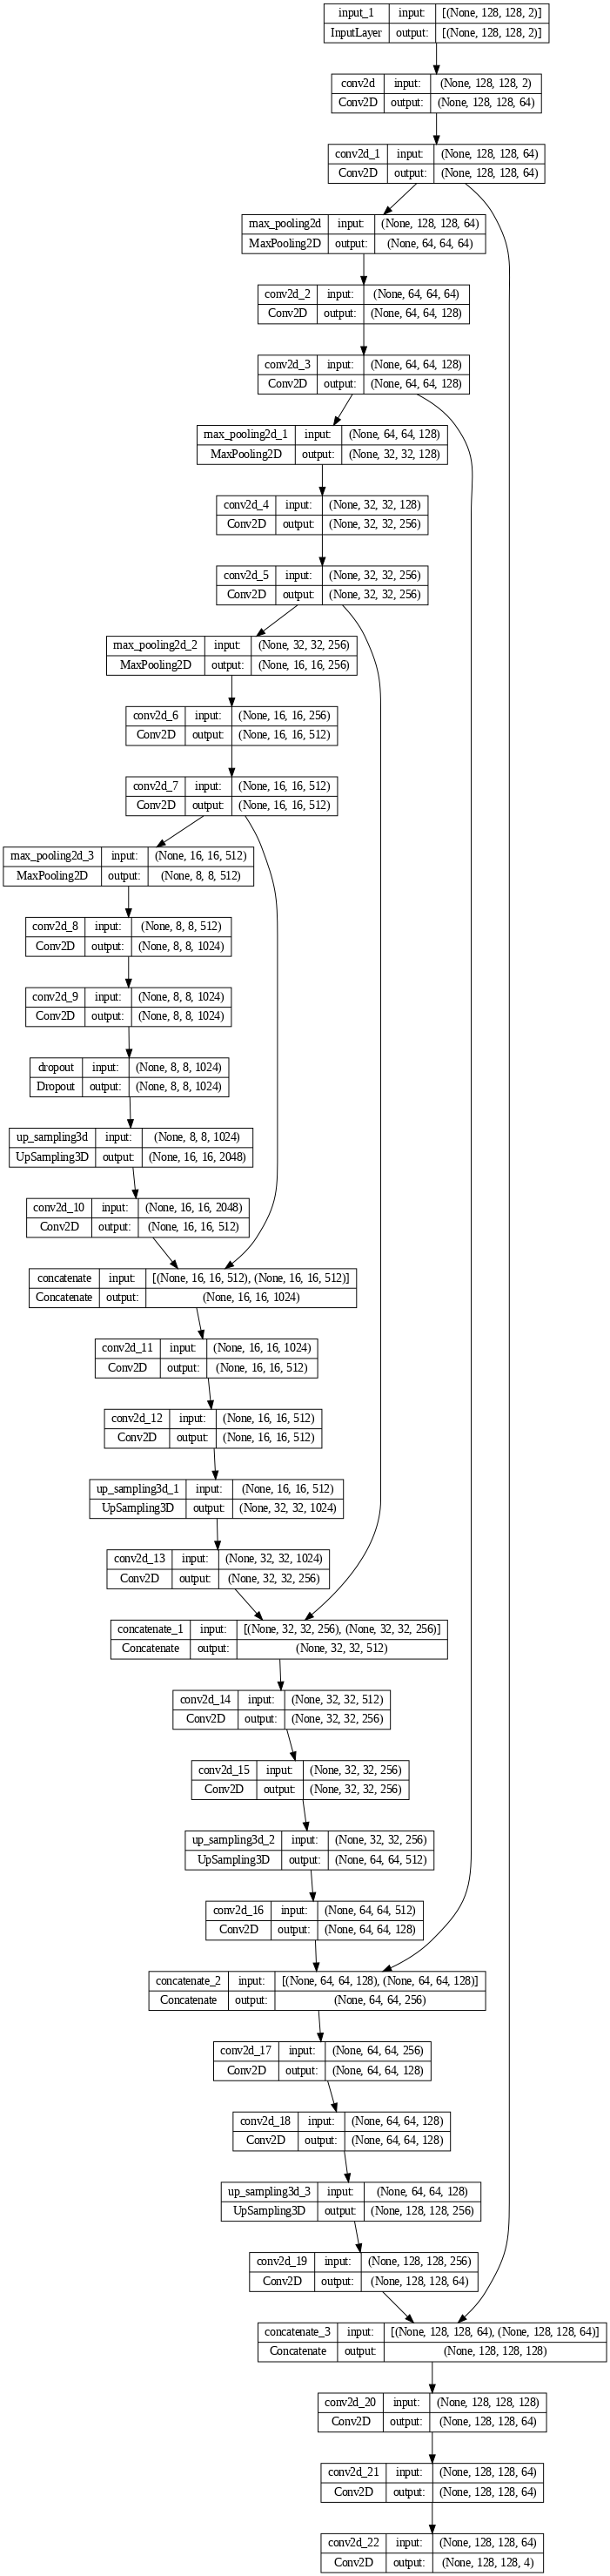

In [15]:
plot_model(model,
           show_shapes = True,
           show_dtype=False,
           show_layer_names = True,
           rankdir = 'TB',
           expand_nested = False,
           dpi = 70
)

## Defining the Data Generators for Training, Validation, and Test Data

In [16]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, id_list, dimensions=(img_size, img_size), batch_size = 1, num_channels = 2, shuffle=True):
        self.dimensions = dimensions
        self.batch_size = batch_size
        self.id_list = id_list
        self.num_classes = 4
        self.labels = classes
        self.num_channels = num_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return math.ceil(len(self.id_list) / self.batch_size)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_ids = [self.id_list[k] for k in indexes]
        X, y = self.__data_generation(batch_ids)
        return X, y

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.id_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, batch_ids):
        X = np.zeros((self.batch_size * num_slices, * self.dimensions, self.num_channels))
        y = np.zeros((self.batch_size * num_slices, 240, 240))
        Y = np.zeros((self.batch_size * num_slices, * self.dimensions, 4))

        for c, i in enumerate(batch_ids):
            case_path = os.path.join(train_dataset_path, f'{i}')

            data_path = os.path.join(case_path, f'{i}_t1.nii');
            t1 = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t1ce.nii');
            ce = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_t2.nii');
            t2 = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_flair.nii');
            flair = nib.load(data_path).get_fdata()

            data_path = os.path.join(case_path, f'{i}_seg.nii');
            seg = nib.load(data_path).get_fdata()

            for j in range(num_slices):
                X[j, :, :, 0] = cv2.resize(flair[:, :, j + slice_start], (img_size, img_size))
                X[j, :, :, 1] = cv2.resize(ce[:, :, j + slice_start], (img_size, img_size))
                y[j, :, :] = seg[:, :, j + slice_start]

        y[y == 4] = 3;
        mask = tf.one_hot(y, 4);
        Y = tf.image.resize(mask, (img_size, img_size));
        return (X / np.max(X)), Y

In [17]:
training_and_test_directories = [f.path for f in os.scandir(train_dataset_path) if f.is_dir()]

def pathListIntoIDs(dirList):
    x = []
    for i in range(0, len(dirList)):
        x.append(dirList[i][dirList[i].rfind('/') + 1:])
    return x

training_and_test_ids = pathListIntoIDs(training_and_test_directories)


training_and_test_ids, validation_ids = train_test_split(training_and_test_ids, test_size=0.2, random_state=24)
training_ids, test_ids = train_test_split(training_and_test_ids, test_size=0.15, random_state=26)

training_generator = DataGenerator(training_ids)
validation_generator = DataGenerator(validation_ids)
test_generator = DataGenerator(test_ids)

------------------------
    Number of Images
------------------------
Training Images:  250
Validation Images:  74
Test Images:  45


Total Images:  369
------------------------




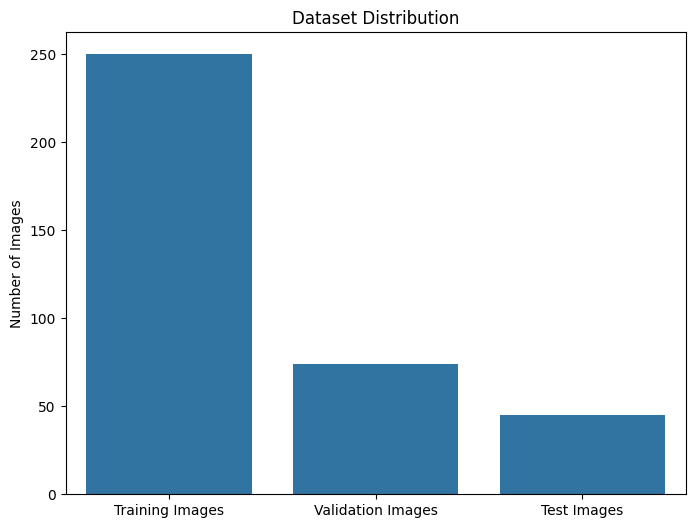

In [18]:
num_training = len(training_ids)
num_validation = len(validation_ids)
num_test = len(test_ids)
num_total = num_training + num_validation + num_test

print("------------------------")
print("    Number of Images")
print("------------------------")
print("Training Images: ", num_training)
print("Validation Images: ", num_validation)
print("Test Images: ", num_test)
print("\n")
print("Total Images: ", num_total)
print("------------------------")
print("\n")

labels = ["Training Images", "Validation Images", "Test Images"]
distribution = [num_training, num_validation, num_test]

dir_to_save = os.path.join(PATH, "presentation")
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=distribution)
plt.ylabel("Number of Images")
plt.title("Dataset Distribution")
plt.savefig(os.path.join(dir_to_save, "dataset_distribution"), dpi=300, bbox_inches='tight')
plt.show()

## Defining Training Parameters and Callback Functions

In [19]:
num_epochs = 50

model_name = "model.test.standardU-net"
save_dir = os.path.join(PATH, model_name)
csv_logger = CSVLogger("training.log", separator=',', append=False)
early_stopping = EarlyStopping(monitor="val_loss", patience=10, verbose=1)
checkpoint_save = ModelCheckpoint(save_dir, monitor="val_loss", restore_best_weights=True, save_best_only=True)
reduce_lr_loss = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, verbose=1, min_delta=1e-4)

## Setting Google Colab Hardware Settings

In [20]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print("Not connected to a GPU")
else:
  print(gpu_info)

Fri May  3 04:33:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0              52W / 400W |    679MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [21]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print("Not using a high-RAM runtime")
else:
  print("You are using a high-RAM runtime!")

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!


## Training and Saving the Model

In [22]:
# history = model.fit(training_generator,
#                     epochs=num_epochs,
#                     steps_per_epoch=num_training,
#                     batch_size=1,
#                     callbacks=[early_stopping, checkpoint_save, reduce_lr_loss, csv_logger],
#                     validation_data=validation_generator
#                    )
# model.save(model_name)

## Displaying a Model Summary

In [23]:
# model.summary()

## Loading the Best Model

In [24]:
best_model = model = tf.keras.models.load_model(os.path.join(PATH, "model.trial.standardU-net"), custom_objects={"accuracy" : "accuracy",
                                                                                                      "mean_io_u_5" : tf.keras.metrics.MeanIoU(num_classes=4),
                                                                                                      "dice_coef": dice_coef,
                                                                                                      "precision": precision,
                                                                                                      "recall": recall,
                                                                                                      "dice_coef_necrotic": dice_coef_necrotic,
                                                                                                      "dice_coef_edema": dice_coef_edema,
                                                                                                      "dice_coef_enhancing": dice_coef_enhancing
                                                                                                    }, compile=True)

## Generating and Displaying the Best Model's Statistics

---------------------------------
       Training Statistics
---------------------------------
Training Loss: 0.7805%
Validation Loss: 1.5347%


Training Accuracy: 99.7200%
Validation Accuracy: 99.5363%


Training Mean IOU: 87.6619%
Validation Mean IOU: 87.6028%


Training Dice Coef: 71.7977%
Validation Dice Coef: 69.8089%
---------------------------------


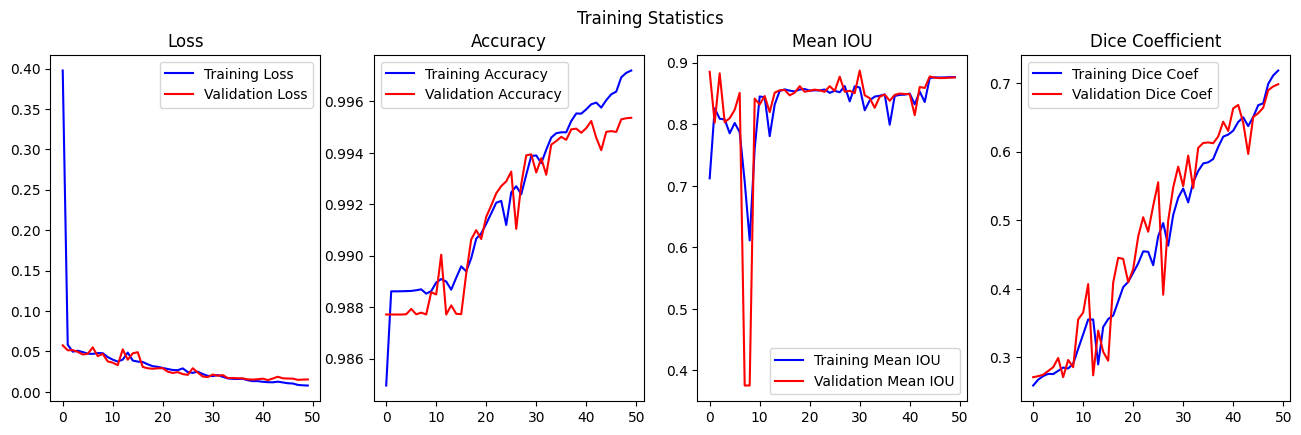

In [25]:
hist = pd.read_csv(os.path.join(PATH, "model.trial.standardU-net/training.log"), sep=',', engine='python')

acc = hist["accuracy"]
val_acc  =hist["val_accuracy"]

epoch = range(len(acc))

loss = hist["loss"]
val_loss = hist["val_loss"]

train_dice = hist["dice_coef"]
val_dice = hist["val_dice_coef"]

train_mean_iou = hist["mean_io_u_5"]
val_mean_iou = hist["val_mean_io_u_5"]

print("---------------------------------")
print("       Training Statistics")
print("---------------------------------")
print(f"Training Loss: {(loss.iat[-1]*100):.4f}%")
print(f"Validation Loss: {val_loss.iat[-1]*100:.4f}%")
print('\n')
print(f"Training Accuracy: {acc.iat[-1]*100:.4f}%")
print(f"Validation Accuracy: {val_acc.iat[-1]*100:.4f}%")
print('\n')
print(f"Training Mean IOU: {train_mean_iou.iat[-1]*100:.4f}%")
print(f"Validation Mean IOU: {val_mean_iou.iat[-1]*100:.4f}%")
print('\n')
print(f"Training Dice Coef: {train_dice.iat[-1]*100:.4f}%")
print(f"Validation Dice Coef: {val_dice.iat[-1]*100:.4f}%")
print("---------------------------------")

figure, ax = plt.subplots(1,4,figsize=(16,4.5))

ax[0].plot(epoch,loss,'b',label='Training Loss')
ax[0].plot(epoch,val_loss,'r',label='Validation Loss')
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(epoch,acc,'b',label='Training Accuracy')
ax[1].plot(epoch,val_acc,'r',label='Validation Accuracy')
ax[1].set_title("Accuracy")
ax[1].legend()

ax[2].plot(epoch,train_mean_iou,'b',label='Training Mean IOU')
ax[2].plot(epoch,val_mean_iou,'r',label='Validation Mean IOU')
ax[2].set_title("Mean IOU")
ax[2].legend()

ax[3].plot(epoch,train_dice,'b',label='Training Dice Coef')
ax[3].plot(epoch,val_dice,'r',label='Validation Dice Coef')
ax[3].set_title("Dice Coefficient")
ax[3].legend()

plt.suptitle("Training Statistics")
plt.savefig(os.path.join(dir_to_save, "training stats"), dpi=300, bbox_inches='tight')

plt.show()

## Predicting and Displaying Select Test Cases

5/5 [==============================] - 5s 348ms/step


<Figure size 1800x5000 with 0 Axes>

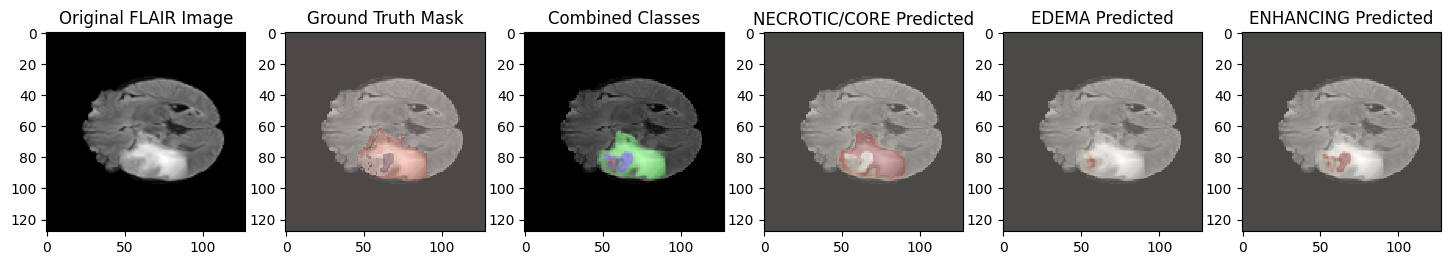

5/5 [==============================] - 0s 44ms/step


<Figure size 1800x5000 with 0 Axes>

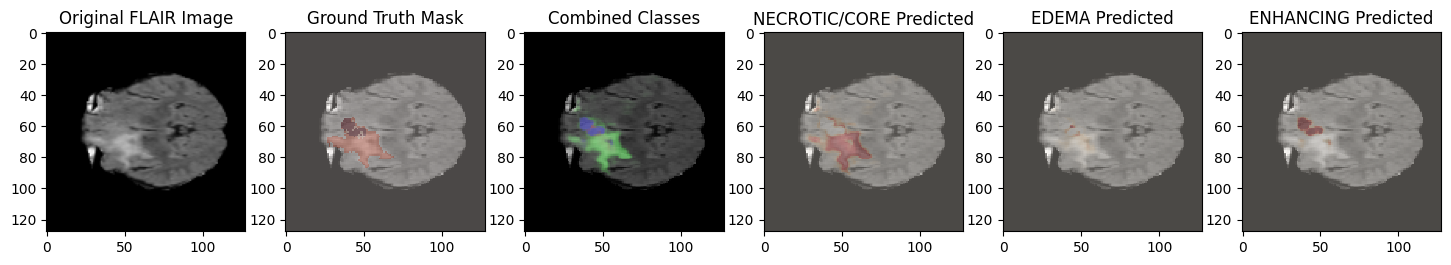

5/5 [==============================] - 0s 45ms/step


<Figure size 1800x5000 with 0 Axes>

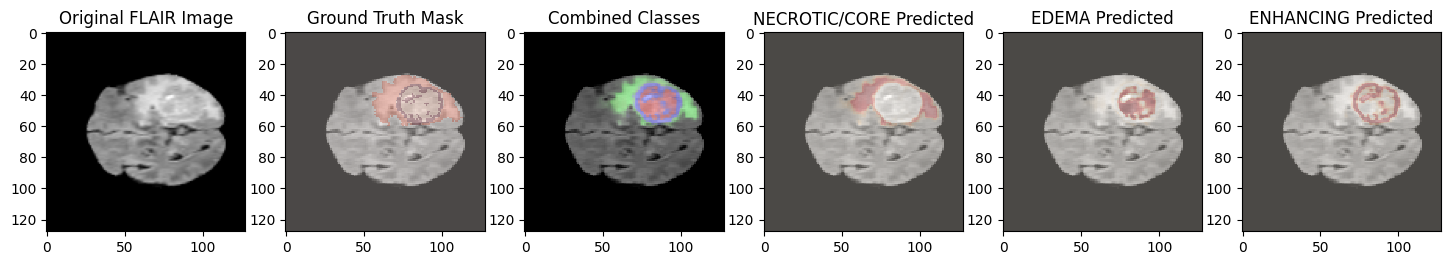

5/5 [==============================] - 0s 43ms/step


<Figure size 1800x5000 with 0 Axes>

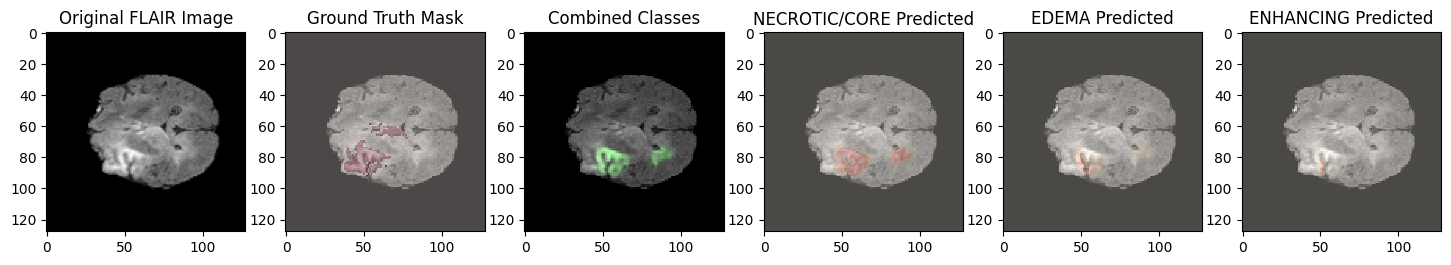

5/5 [==============================] - 0s 45ms/step


<Figure size 1800x5000 with 0 Axes>

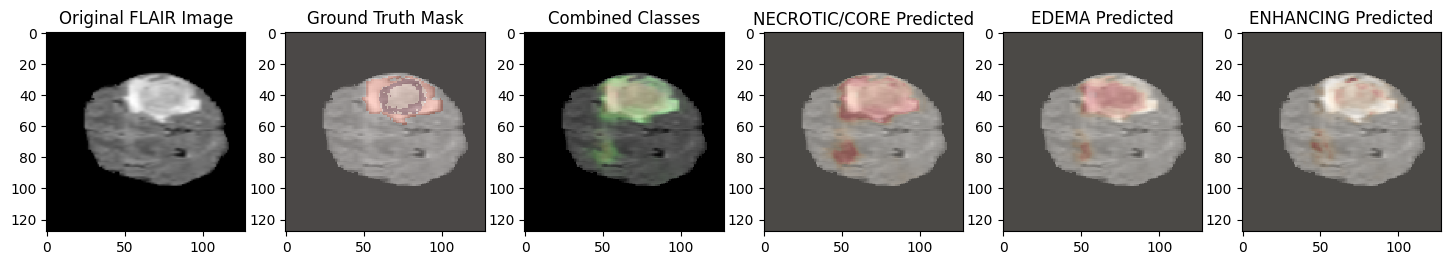

In [26]:
def predictByPath(case_path,case):
    files = next(os.walk(case_path))[2]
    X = np.empty((num_slices, img_size, img_size, 2))

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii');
    flair=nib.load(vol_path).get_fdata()

    vol_path = os.path.join(case_path, f'BraTS20_Training_{case}_t1ce.nii');
    ce=nib.load(vol_path).get_fdata()


    for j in range(num_slices):
        X[j, :, :, 0] = cv2.resize(flair[:, :, j + slice_start], (img_size, img_size))
        X[j, :, :, 1] = cv2.resize(ce[:, :, j + slice_start], (img_size, img_size))

    return best_model.predict(X/np.max(X), verbose=1)


def showPredictsById(case, start_slice = 60):
    case_path = os.path.join(train_dataset_path, f"BraTS20_Training_{case}")
    gt = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_seg.nii')).get_fdata()
    origImage = nib.load(os.path.join(case_path, f'BraTS20_Training_{case}_flair.nii')).get_fdata()
    p = predictByPath(case_path, case)

    core = p[:,:,:,1]
    edema= p[:,:,:,2]
    enhancing = p[:,:,:,3]

    plt.figure(figsize=(18, 50))
    f, axarr = plt.subplots(1,6, figsize = (18, 50))

    for i in range(6):
        axarr[i].imshow(cv2.resize(origImage[:, :, start_slice + slice_start], (img_size, img_size)), cmap="gray", interpolation='none')

    axarr[0].imshow(cv2.resize(origImage[:, :, start_slice + slice_start], (img_size, img_size)), cmap="gray")
    axarr[0].title.set_text('Original FLAIR Image')
    curr_gt=cv2.resize(gt[:, :, start_slice + slice_start], (img_size, img_size), interpolation = cv2.INTER_NEAREST)
    axarr[1].imshow(curr_gt, cmap="Reds", interpolation='none', alpha=0.3)
    axarr[1].title.set_text('Ground Truth Mask')
    axarr[2].imshow(p[start_slice, :, :, 1:4], cmap="Reds", interpolation='none', alpha=0.3)
    axarr[2].title.set_text('Combined Classes')
    axarr[3].imshow(edema[start_slice, :, :], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[3].title.set_text(f'{classes[1]} Predicted')
    axarr[4].imshow(core[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[4].title.set_text(f'{classes[2]} Predicted')
    axarr[5].imshow(enhancing[start_slice, :, ], cmap="OrRd", interpolation='none', alpha=0.3)
    axarr[5].title.set_text(f'{classes[3]} Predicted')
    plt.show()


showPredictsById(case=test_ids[0][-3:])
showPredictsById(case=test_ids[1][-3:])
showPredictsById(case=test_ids[2][-3:])
showPredictsById(case=test_ids[4][-3:])
showPredictsById(case=test_ids[5][-3:])

## Evaluating the Best Model

In [27]:
results = best_model.evaluate(test_generator, batch_size=1, callbacks=[early_stopping, checkpoint_save, reduce_lr_loss, csv_logger])

45/45 [==============================] - 150s 3s/step - loss: 0.0178 - accuracy: 0.9942 - mean_io_u_5: 0.8200 - dice_coef: 0.6615 - precision: 0.9946 - recall: 0.9932 - dice_coef_necrotic: 0.6539 - dice_coef_edema: 0.7440 - dice_coef_enhancing: 0.7457
